In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
project1Data = pd.read_excel('card transactions unsupervised.xlsx')


In [3]:
"""
****** Data Preparation*******
--> Selecting only P values
--> Remove outliers from amount (pesos one)
--> Imputing missing values
--> Adding the variables.
"""

project1Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 9 columns):
Recnum               96753 non-null int64
Cardnum              96753 non-null int64
Date                 96753 non-null datetime64[ns]
Merchnum             93378 non-null object
Merch description    96753 non-null object
Merch state          95558 non-null object
Merch zip            92097 non-null float64
Transtype            96753 non-null object
Amount               96753 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 6.6+ MB


In [4]:
project1Data.isnull().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3375
Merch description       0
Merch state          1195
Merch zip            4656
Transtype               0
Amount                  0
dtype: int64

In [5]:
## Filtered out non P trans ype
project1DataCopy = project1Data[project1Data.Transtype=='P'].copy()

In [6]:
project1DataCopy['Transtype'].value_counts()

P    96398
Name: Transtype, dtype: int64

In [7]:
## Removed amount outlier
project1DataCopy = project1DataCopy[project1DataCopy.Amount<300000].copy()

In [8]:
project1DataCopy.describe()

Recnum        Cardnum  Merch zip    Amount
count 96397.000      96397.000  92097.000 96397.000
mean  48365.482 5142201667.062  44706.597   395.858
std   27945.004      55658.254  28369.538   832.330
min       1.000 5142110002.000      1.000     0.010
25%   24154.000 5142152067.000  20855.000    33.460
50%   48365.000 5142195612.000  38118.000   137.980
75%   72578.000 5142245297.000  63103.000   428.250
max   96753.000 5142847398.000  99999.000 47900.000

Following Steps are to impute null values.

In [9]:
def ReplaceMissingValue(columnList,project1DataCopy):
    missingColumn = columnList[0]
    MerchZipImputeStep1 = project1DataCopy[columnList].dropna(axis=0,how='any').groupby(columnList[1:]).agg(lambda x:x.value_counts().index[0]).reset_index()
    project1DataCopy = project1DataCopy.merge(MerchZipImputeStep1,how='left',
                      left_on=columnList[1:],
                      right_on=columnList[1:],validate='many_to_one').rename(columns={missingColumn+'_x':missingColumn})
    project1DataCopy[missingColumn].fillna(project1DataCopy[missingColumn+'_y'],inplace=True)
    project1DataCopy.drop(missingColumn+'_y',axis=1,inplace=True)
    return(project1DataCopy)

In [10]:
project1DataCopy['Merchnum'].isnull().sum()

3198

In [11]:
project1DataCopy = ReplaceMissingValue(['Merchnum','Merch description','Merch zip'],project1DataCopy)

In [12]:
project1DataCopy['Merchnum'].isnull().sum()

2159

In [13]:
project1DataCopy = ReplaceMissingValue(['Merchnum','Merch description'],project1DataCopy)

In [14]:
project1DataCopy['Merchnum'].isnull().sum()

2038

In [15]:
project1DataCopy = ReplaceMissingValue(['Merch state','Merch zip'],project1DataCopy)

In [16]:
project1DataCopy['Merch state'].isnull().sum()

1000

In [17]:
project1DataCopy = ReplaceMissingValue(['Merch state','Merchnum'],project1DataCopy)

In [18]:
project1DataCopy['Merch state'].isnull().sum()

968

In [19]:
project1DataCopy = ReplaceMissingValue(['Merch state','Cardnum'],project1DataCopy)

In [20]:
project1DataCopy['Merch state'].isnull().sum()

35

In [21]:
project1DataCopy = ReplaceMissingValue(['Merch zip','Merchnum'],project1DataCopy)

In [22]:
project1DataCopy['Merch zip'].isnull().sum()

2405

In [23]:
project1DataCopy = ReplaceMissingValue(['Merch zip','Cardnum'],project1DataCopy)

In [24]:
project1DataCopy['Merch zip'].isnull().sum()

45

In [25]:
project1DataCopy = ReplaceMissingValue(['Merch zip','Merch state'],project1DataCopy)

In [26]:
project1DataCopy['Merch zip'].isnull().sum()

35

In [27]:
project1DataCopy['Merchnum'].fillna(project1DataCopy['Recnum'].astype(str)+'missing',inplace=True)
project1DataCopy['Merch state'].fillna(project1DataCopy['Recnum'].astype(str)+'missing',inplace=True)
project1DataCopy['Merch zip'].fillna(project1DataCopy['Recnum'].astype(str)+'missing',inplace=True)

In [28]:
project1DataCopy.isnull().sum()

Recnum               0
Cardnum              0
Date                 0
Merchnum             0
Merch description    0
Merch state          0
Merch zip            0
Transtype            0
Amount               0
dtype: int64

In [29]:
"""Adding variables"""
project1DataCopy.to_csv('NonMissingData.csv')


In [30]:
"""
Get Average Scores By card/Merc MOnth and day Of week
"""

project1DataCopy['Date-Month'] = pd.to_datetime(project1DataCopy['Date']).map(lambda x:x.month)
project1DataCopy['Date-DayOfWeek'] = pd.to_datetime(project1DataCopy['Date']).map(lambda x:x.dayofweek)

In [31]:
### Average Amount  and total Trx card and merchant


AvgCardAmnt = project1DataCopy[['Cardnum','Amount']].groupby('Cardnum').agg(['mean','count']).reset_index()
AvgCardAmnt.columns =['Cardnum','CardAvgAmount','CardTotalTrxCount']
project1DataCopy = project1DataCopy.merge(AvgCardAmnt,how='left',validate='m:1')
project1DataCopy['AvgCardScore'] = project1DataCopy['Amount'].div(project1DataCopy['CardAvgAmount']) 

AvgMerchAmnt = project1DataCopy[['Merchnum','Amount']].groupby('Merchnum').agg(['mean','count']).reset_index()
AvgMerchAmnt.columns =['Merchnum','MerchAvgAmount','MerchTotalTrxCount']
project1DataCopy = project1DataCopy.merge(AvgMerchAmnt,how='left',validate='m:1')
project1DataCopy['AvgMerchScore'] = project1DataCopy['Amount'].div(project1DataCopy['MerchAvgAmount']) 

In [32]:
### Average Amount  and total Trx (month and day of week) card and merchant

AvgCardMonthlyAmt = project1DataCopy[['Cardnum','Date-Month','Amount']].groupby(['Cardnum','Date-Month']).agg(['mean','count']).reset_index()
AvgCardMonthlyAmt.columns = ['Cardnum','Date-Month','CardMnthAvgAmnt','CardMnthTotalTrx']
project1DataCopy = project1DataCopy.merge(AvgCardMonthlyAmt,how='left',validate='m:1')
project1DataCopy['AvgCardScoreMnth'] = project1DataCopy['Amount'].div(project1DataCopy['CardMnthAvgAmnt']) 

AvgMerchMonthlyAmt = project1DataCopy[['Merchnum','Date-Month','Amount']].groupby(['Merchnum','Date-Month']).agg(['mean','count']).reset_index()
AvgMerchMonthlyAmt.columns = ['Merchnum','Date-Month','MerchMnthAvgAmnt','MerchMnthTotalTrx']
project1DataCopy = project1DataCopy.merge(AvgMerchMonthlyAmt,how='left',validate='m:1')
project1DataCopy['AvgMerchScoreMnth'] = project1DataCopy['Amount'].div(project1DataCopy['MerchMnthAvgAmnt']) 

AvgCarddayOfWeekAmt = project1DataCopy[['Cardnum','Date-DayOfWeek','Amount']].groupby(['Cardnum','Date-DayOfWeek']).agg(['mean','count']).reset_index()
AvgCarddayOfWeekAmt.columns = ['Cardnum','Date-DayOfWeek','CardDayAvgAmnt','CardDayTotalTrx']
project1DataCopy = project1DataCopy.merge(AvgCarddayOfWeekAmt,how='left',validate='m:1')
project1DataCopy['AvgCardScoreDay'] = project1DataCopy['Amount'].div(project1DataCopy['CardDayAvgAmnt'])

AvgMerchdayOfWeekAmt = project1DataCopy[['Merchnum','Date-DayOfWeek','Amount']].groupby(['Merchnum','Date-DayOfWeek']).agg(['mean','count']).reset_index()
AvgMerchdayOfWeekAmt.columns = ['Merchnum','Date-DayOfWeek','MerchDayAvgAmnt','MerchDayTotalTrx']
project1DataCopy = project1DataCopy.merge(AvgMerchdayOfWeekAmt,how='left',validate='m:1')
project1DataCopy['AvgMerchScoreDay'] = project1DataCopy['Amount'].div(project1DataCopy['MerchDayAvgAmnt'])

In [33]:
### Lag 1 and 2 variable for card number

#project1DataCopy = project1DataCopy.sort_values(['Cardnum','Date'])
#project1DataCopy['CardAmount_Lag1']=project1DataCopy.groupby('Cardnum')['Amount'].shift()
#project1DataCopy['CardAmount_Lag2']=project1DataCopy.groupby('Cardnum')['Amount'].shift(2)

In [34]:
### Lag 1 and 2 variable for merchant number

#project1DataCopy = project1DataCopy.sort_values(['Merchnum','Date'])
#project1DataCopy['MerchAmount_Lag1']=project1DataCopy.groupby('Merchnum')['Amount'].shift()
#project1DataCopy['MerchAmount_Lag2']=project1DataCopy.groupby('Merchnum')['Amount'].shift(2)

In [35]:
### Unique merchant for a card
cardUniqueMerchant = project1DataCopy[['Cardnum','Merchnum']].groupby('Cardnum').agg(pd.Series.nunique).reset_index()
cardUniqueMerchant.columns=['Cardnum','UniqueMerch']
project1DataCopy = project1DataCopy.merge(cardUniqueMerchant,how='left',validate='m:1')

cardUniqueMerchantMnth = project1DataCopy[['Cardnum','Date-Month','Merchnum']].groupby(['Cardnum','Date-Month']).agg(pd.Series.nunique).reset_index()
cardUniqueMerchantMnth.columns=['Cardnum','Date-Month','UniqueMerchMonthly']
project1DataCopy = project1DataCopy.merge(cardUniqueMerchantMnth,how='left',validate='m:1')

cardUniqueMerchantDay = project1DataCopy[['Cardnum','Date-DayOfWeek','Merchnum']].groupby(['Cardnum','Date-DayOfWeek']).agg(pd.Series.nunique).reset_index()
cardUniqueMerchantDay.columns=['Cardnum','Date-DayOfWeek','UniqueMerchDay']
project1DataCopy = project1DataCopy.merge(cardUniqueMerchantDay,how='left',validate='m:1')

In [36]:
### Unique card for a merchant
merchUniqueCard = project1DataCopy[['Cardnum','Merchnum']].groupby('Merchnum').agg(pd.Series.nunique).reset_index()
merchUniqueCard.columns=['Merchnum','UniqueCard']
project1DataCopy = project1DataCopy.merge(merchUniqueCard,how='left',validate='m:1')

merchUniqueCardMnth = project1DataCopy[['Cardnum','Date-Month','Merchnum']].groupby(['Merchnum','Date-Month']).agg(pd.Series.nunique).reset_index()
merchUniqueCardMnth.columns=['Merchnum','Date-Month','UniqueCardMonthly']
project1DataCopy = project1DataCopy.merge(merchUniqueCardMnth,how='left',validate='m:1')

merchUniqueCardDay = project1DataCopy[['Cardnum','Date-DayOfWeek','Merchnum']].groupby(['Merchnum','Date-DayOfWeek']).agg(pd.Series.nunique).reset_index()
merchUniqueCardDay.columns=['Merchnum','Date-DayOfWeek','UniqueCardDay']
project1DataCopy = project1DataCopy.merge(merchUniqueCardDay,how='left',validate='m:1')

In [37]:
"""
Rolling sum of past transaction amount and count at card level
"""
project1DataCopy = project1DataCopy.sort_values(['Cardnum','Date'])
project1DataCopy['AmountRollingSum11'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 11,1)
project1DataCopy['AmountRollingSum10'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 10,1)
project1DataCopy['AmountRollingSum09'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 9,1)
project1DataCopy['AmountRollingSum08'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 8,1)
project1DataCopy['AmountRollingSum07'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 7,1)
project1DataCopy['AmountRollingSum06'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 6,1)
project1DataCopy['AmountRollingSum05'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 5,1)
project1DataCopy['AmountRollingSum04'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 4,1)
project1DataCopy['AmountRollingSum03'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 3,1)
project1DataCopy['AmountRollingSum02'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 2,1)
project1DataCopy['AmountRollingSum01'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_sum, 1,1)


project1DataCopy['AmountRollingTrx11'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 11)
project1DataCopy['AmountRollingTrx10'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 10)
project1DataCopy['AmountRollingTrx09'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 9)
project1DataCopy['AmountRollingTrx08'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 8)
project1DataCopy['AmountRollingTrx07'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 7)
project1DataCopy['AmountRollingTrx06'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 6)
project1DataCopy['AmountRollingTrx05'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 5)
project1DataCopy['AmountRollingTrx04'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 4)
project1DataCopy['AmountRollingTrx03'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 3)
project1DataCopy['AmountRollingTrx02'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 2)
project1DataCopy['AmountRollingTrx01'] = project1DataCopy.groupby('Cardnum').Amount.apply(pd.rolling_count, 1)

In [38]:
"""
Rolling sum of past transaction amount and count at merchant level level
"""
project1DataCopy = project1DataCopy.sort_values(['Merchnum','Date'])
project1DataCopy['MerchAmountRollingSum11'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 11,1)
project1DataCopy['MerchAmountRollingSum10'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 10,1)
project1DataCopy['MerchAmountRollingSum09'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 9,1)
project1DataCopy['MerchAmountRollingSum08'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 8,1)
project1DataCopy['MerchAmountRollingSum07'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 7,1)
project1DataCopy['MerchAmountRollingSum06'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 6,1)
project1DataCopy['MerchAmountRollingSum05'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 5,1)
project1DataCopy['MerchAmountRollingSum04'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 4,1)
project1DataCopy['MerchAmountRollingSum03'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 3,1)
project1DataCopy['MerchAmountRollingSum02'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 2,1)
project1DataCopy['MerchAmountRollingSum01'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_sum, 1,1)

project1DataCopy['MerchAmountRollingTrx11'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 11)
project1DataCopy['MerchAmountRollingTrx10'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 10)
project1DataCopy['MerchAmountRollingTrx09'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 9)
project1DataCopy['MerchAmountRollingTrx08'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 8)
project1DataCopy['MerchAmountRollingTrx07'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 7)
project1DataCopy['MerchAmountRollingTrx06'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 6)
project1DataCopy['MerchAmountRollingTrx05'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 5)
project1DataCopy['MerchAmountRollingTrx04'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 4)
project1DataCopy['MerchAmountRollingTrx03'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 3)
project1DataCopy['MerchAmountRollingTrx02'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 2)
project1DataCopy['MerchAmountRollingTrx01'] = project1DataCopy.groupby('Merchnum').Amount.apply(pd.rolling_count, 1)

In [39]:
"""
Rolling sum of past transaction amount and count at card/merch level
"""
project1DataCopy = project1DataCopy.sort_values(['Cardnum','Merchnum','Date'])
project1DataCopy['CMAmountRollingSum11'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 11,1)
project1DataCopy['CMAmountRollingSum10'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 10,1)
project1DataCopy['CMAmountRollingSum09'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 9,1)
project1DataCopy['CMAmountRollingSum08'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 8,1)
project1DataCopy['CMAmountRollingSum07'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 7,1)
project1DataCopy['CMAmountRollingSum06'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 6,1)
project1DataCopy['CMAmountRollingSum05'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 5,1)
project1DataCopy['CMAmountRollingSum04'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 4,1)
project1DataCopy['CMAmountRollingSum03'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 3,1)
project1DataCopy['CMAmountRollingSum02'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 2,1)
project1DataCopy['CMAmountRollingSum01'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_sum, 1,1)


project1DataCopy['CMAmountRollingTrx11'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 11)
project1DataCopy['CMAmountRollingTrx10'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 10)
project1DataCopy['CMAmountRollingTrx09'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 9)
project1DataCopy['CMAmountRollingTrx08'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 8)
project1DataCopy['CMAmountRollingTrx07'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 7)
project1DataCopy['CMAmountRollingTrx06'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 6)
project1DataCopy['CMAmountRollingTrx05'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 5)
project1DataCopy['CMAmountRollingTrx04'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 4)
project1DataCopy['CMAmountRollingTrx03'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 3)
project1DataCopy['CMAmountRollingTrx02'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 2)
project1DataCopy['CMAmountRollingTrx01'] = project1DataCopy.groupby(['Cardnum','Merchnum']).Amount.apply(pd.rolling_count, 1)

In [40]:
### Average Amount  and total Trx card and merchant zip


AvgCardAmntZip = project1DataCopy[['Cardnum','Merch zip','Amount']].groupby(['Cardnum','Merch zip']).agg(['mean','count']).reset_index()
AvgCardAmntZip.columns =['Cardnum','Merch zip','CardAvgAmountZip','CardTotalTrxCountZip']
project1DataCopy = project1DataCopy.merge(AvgCardAmntZip,how='left',validate='m:1')
project1DataCopy['AvgCardScoreZip'] = project1DataCopy['Amount'].div(project1DataCopy['CardAvgAmountZip']) 

AvgCardMonthlyAmtZip = project1DataCopy[['Cardnum','Merch zip','Date-Month','Amount']].groupby(['Cardnum','Merch zip','Date-Month']).agg(['mean','count']).reset_index()
AvgCardMonthlyAmtZip.columns = ['Cardnum','Merch zip','Date-Month','CardMnthAvgAmntZip','CardMnthTotalTrxZip']
project1DataCopy = project1DataCopy.merge(AvgCardMonthlyAmtZip,how='left',validate='m:1')
project1DataCopy['AvgCardScoreMnthZip'] = project1DataCopy['Amount'].div(project1DataCopy['CardMnthAvgAmntZip']) 

AvgCarddayOfWeekAmtZip = project1DataCopy[['Cardnum','Merch zip','Date-DayOfWeek','Amount']].groupby(['Cardnum','Merch zip','Date-DayOfWeek']).agg(['mean','count']).reset_index()
AvgCarddayOfWeekAmtZip.columns = ['Cardnum','Merch zip','Date-DayOfWeek','CardDayAvgAmntZip','CardDayTotalTrxZip']
project1DataCopy = project1DataCopy.merge(AvgCarddayOfWeekAmtZip,how='left',validate='m:1')
project1DataCopy['AvgCardScoreDayZip'] = project1DataCopy['Amount'].div(project1DataCopy['CardDayAvgAmntZip'])

In [41]:
### Average Amount  and total Trx card and merchant
AvgCardAmntMerch = project1DataCopy[['Cardnum','Merchnum','Amount']].groupby(['Cardnum','Merchnum']).agg(['mean','count']).reset_index()
AvgCardAmntMerch.columns =['Cardnum','Merchnum','CardAvgAmountMerch','CardTotalTrxCountMerch']
project1DataCopy = project1DataCopy.merge(AvgCardAmntMerch,how='left',validate='m:1')
project1DataCopy['AvgCardScoreMerch'] = project1DataCopy['Amount'].div(project1DataCopy['CardAvgAmountMerch']) 

AvgCardMonthlyAmtMerch = project1DataCopy[['Cardnum','Merchnum','Date-Month','Amount']].groupby(['Cardnum','Merchnum','Date-Month']).agg(['mean','count']).reset_index()
AvgCardMonthlyAmtMerch.columns = ['Cardnum','Merchnum','Date-Month','CardMnthAvgAmntMerch','CardMnthTotalTrxMerch']
project1DataCopy = project1DataCopy.merge(AvgCardMonthlyAmtMerch,how='left',validate='m:1')
project1DataCopy['AvgCardScoreMnthMerch'] = project1DataCopy['Amount'].div(project1DataCopy['CardMnthAvgAmntMerch']) 

AvgCarddayOfWeekAmtMerch = project1DataCopy[['Cardnum','Merchnum','Date-DayOfWeek','Amount']].groupby(['Cardnum','Merchnum','Date-DayOfWeek']).agg(['mean','count']).reset_index()
AvgCarddayOfWeekAmtMerch.columns = ['Cardnum','Merchnum','Date-DayOfWeek','CardDayAvgAmntMerch','CardDayTotalTrxMerch']
project1DataCopy = project1DataCopy.merge(AvgCarddayOfWeekAmtMerch,how='left',validate='m:1')
project1DataCopy['AvgCardScoreDayMerch'] = project1DataCopy['Amount'].div(project1DataCopy['CardDayAvgAmntMerch'])

In [42]:
# ### Average Amount  and total merchant and zip

AvgMerchAmntZip = project1DataCopy[['Merchnum','Merch zip','Amount']].groupby(['Merchnum','Merch zip']).agg(['mean','count']).reset_index()
AvgMerchAmntZip.columns =['Merchnum','Merch zip','MerchAvgAmountZip','MerchTotalTrxCountZip']
project1DataCopy = project1DataCopy.merge(AvgMerchAmntZip,how='left',validate='m:1')
project1DataCopy['AvgMerchScoreZip'] = project1DataCopy['Amount'].div(project1DataCopy['MerchAvgAmountZip']) 

AvgMerchMonthlyAmtZip = project1DataCopy[['Merchnum','Merch zip','Date-Month','Amount']].groupby(['Merchnum','Merch zip','Date-Month']).agg(['mean','count']).reset_index()
AvgMerchMonthlyAmtZip.columns = ['Merchnum','Merch zip','Date-Month','MerchMnthAvgAmntZip','MerchMnthTotalTrxZip']
project1DataCopy = project1DataCopy.merge(AvgMerchMonthlyAmtZip,how='left',validate='m:1')
project1DataCopy['AvgMerchScoreMnthZip'] = project1DataCopy['Amount'].div(project1DataCopy['MerchMnthAvgAmntZip']) 

AvgMerchdayOfWeekAmtZip = project1DataCopy[['Merchnum','Merch zip','Date-DayOfWeek','Amount']].groupby(['Merchnum','Merch zip','Date-DayOfWeek']).agg(['mean','count']).reset_index()
AvgMerchdayOfWeekAmtZip.columns = ['Merchnum','Merch zip','Date-DayOfWeek','MerchDayAvgAmntZip','MerchDayTotalTrxZip']
project1DataCopy = project1DataCopy.merge(AvgMerchdayOfWeekAmtZip,how='left',validate='m:1')
project1DataCopy['AvgMerchScoreDayZip'] = project1DataCopy['Amount'].div(project1DataCopy['MerchDayAvgAmntZip'])


In [43]:
FinalDataset = project1DataCopy[project1DataCopy.columns[11:]]

In [44]:
FinalDataset.isnull().sum()

CardAvgAmount             0
CardTotalTrxCount         0
AvgCardScore              0
MerchAvgAmount            0
MerchTotalTrxCount        0
AvgMerchScore             0
CardMnthAvgAmnt           0
CardMnthTotalTrx          0
AvgCardScoreMnth          0
MerchMnthAvgAmnt          0
MerchMnthTotalTrx         0
AvgMerchScoreMnth         0
CardDayAvgAmnt            0
CardDayTotalTrx           0
AvgCardScoreDay           0
MerchDayAvgAmnt           0
MerchDayTotalTrx          0
AvgMerchScoreDay          0
UniqueMerch               0
UniqueMerchMonthly        0
UniqueMerchDay            0
UniqueCard                0
UniqueCardMonthly         0
UniqueCardDay             0
AmountRollingSum11        0
AmountRollingSum10        0
AmountRollingSum09        0
AmountRollingSum08        0
AmountRollingSum07        0
AmountRollingSum06        0
                         ..
CMAmountRollingTrx03      0
CMAmountRollingTrx02      0
CMAmountRollingTrx01      0
CardAvgAmountZip          0
CardTotalTrxCountZip

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
scaler = StandardScaler()

In [47]:
FinalDatasetScaled = scaler.fit_transform(FinalDataset)

In [48]:
from sklearn.decomposition import PCA
#n_batches = 100
pca = PCA()
X_reduced = pca.fit(FinalDatasetScaled) 

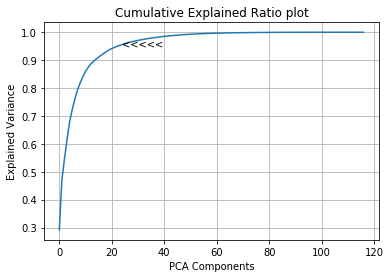

In [49]:
## looks like about 24-25 explained 95% pf variance
## We will look for 95% varaince expalined
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained Variance')
plt.xlabel('PCA Components')
plt.title('Cumulative Explained Ratio plot')
plt.annotate(s='<<<<<',xy=[24,.95])
plt.grid()
plt.show()

In [50]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(FinalDatasetScaled) 

In [51]:
### Reduced the shape from 117 to 24, with PCA explaining 95 percent variation
X_reduced.shape

(96397, 24)

In [52]:
scalerAfter = StandardScaler()
XreducedScaled = scalerAfter.fit_transform(X_reduced)

In [53]:
### Following is the reduced scaled version of our dataset
XreducedScaled

array([[-5.29234124e-01, -2.31646278e+00,  4.09337331e+00, ...,
        -3.13386132e-01,  6.46065698e-01, -2.02308073e-01],
       [-1.77023169e-01, -2.28333390e+00,  4.17355231e+00, ...,
         1.46873417e-01,  1.01535604e+00, -1.29175710e-01],
       [ 1.07951339e-04, -1.98220341e+00,  2.91592374e+00, ...,
        -4.50489369e-01,  7.65502869e-01,  1.06657093e-01],
       ...,
       [ 5.57561383e-02,  7.46434711e-01, -3.34665835e-01, ...,
        -1.79173630e-01, -4.18846357e-01,  2.77904321e-01],
       [-1.69714332e-03,  7.46201385e-01, -4.68688535e-01, ...,
         2.16658075e-01, -2.22632811e-01,  5.50359048e-01],
       [ 2.54288942e-01,  7.72204075e-01,  1.77577117e-02, ...,
         5.02573806e-01, -1.51582078e-02,  4.99886415e-01]])

In [54]:
XreducedScaled.shape

(96397, 24)

In [55]:
FirstFraudScore = np.apply_along_axis( lambda row:np.linalg.norm(row,2), 1, XreducedScaled)

In [60]:
FirstFraudScore.shape

(96397,)

In [62]:
from keras.layers import Input, Dense
from keras.models import Model

In [137]:
encoding_dim = 32 
input_features = Input(shape=(24,))
encoded = Dense(encoding_dim, activation='relu')(input_features)
decoded = Dense(24, activation='sigmoid')(encoded)
autoencoder = Model(input_features, decoded)
encoder = Model(input_features, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

In [138]:
autoencoder.fit(XreducedScaled, XreducedScaled,
                epochs=50,
                batch_size=256,
                shuffle=True)

Epoch 1/50
96397/96397 [==============================] - ETA: 1:18 - loss: 1.1697 - acc: 0.050 - ETA: 3s - loss: 1.1243 - acc: 0.0681  - ETA: 1s - loss: 1.1369 - acc: 0.081 - ETA: 1s - loss: 1.0733 - acc: 0.109 - ETA: 0s - loss: 1.0669 - acc: 0.143 - ETA: 0s - loss: 1.0617 - acc: 0.175 - ETA: 0s - loss: 1.0451 - acc: 0.207 - ETA: 0s - loss: 1.0173 - acc: 0.235 - ETA: 0s - loss: 1.0053 - acc: 0.261 - ETA: 0s - loss: 0.9936 - acc: 0.286 - ETA: 0s - loss: 0.9866 - acc: 0.304 - ETA: 0s - loss: 0.9636 - acc: 0.323 - 1s 8us/step - loss: 0.9544 - acc: 0.3398
Epoch 2/50
96397/96397 [==============================] - ETA: 2s - loss: 0.6052 - acc: 0.531 - ETA: 0s - loss: 0.8026 - acc: 0.529 - ETA: 0s - loss: 0.8563 - acc: 0.533 - ETA: 0s - loss: 0.8632 - acc: 0.532 - ETA: 0s - loss: 0.8337 - acc: 0.531 - ETA: 0s - loss: 0.8139 - acc: 0.534 - ETA: 0s - loss: 0.8059 - acc: 0.538 - ETA: 0s - loss: 0.7880 - acc: 0.540 - ETA: 0s - loss: 0.7939 - acc: 0.542 - ETA: 0s - loss: 0.8137 - acc: 0.547 - ETA

96397/96397 [==============================] - ETA: 1s - loss: 0.8323 - acc: 0.882 - ETA: 0s - loss: 0.6348 - acc: 0.911 - ETA: 0s - loss: 0.6740 - acc: 0.910 - ETA: 0s - loss: 0.6462 - acc: 0.909 - ETA: 0s - loss: 0.6482 - acc: 0.908 - ETA: 0s - loss: 0.6432 - acc: 0.909 - ETA: 0s - loss: 0.6471 - acc: 0.909 - ETA: 0s - loss: 0.6496 - acc: 0.910 - ETA: 0s - loss: 0.6547 - acc: 0.910 - ETA: 0s - loss: 0.6722 - acc: 0.910 - ETA: 0s - loss: 0.6618 - acc: 0.911 - ETA: 0s - loss: 0.6726 - acc: 0.912 - ETA: 0s - loss: 0.6775 - acc: 0.912 - 1s 7us/step - loss: 0.6778 - acc: 0.9127
Epoch 15/50
96397/96397 [==============================] - ETA: 2s - loss: 0.8914 - acc: 0.890 - ETA: 0s - loss: 0.7686 - acc: 0.918 - ETA: 0s - loss: 0.7386 - acc: 0.917 - ETA: 0s - loss: 0.6949 - acc: 0.915 - ETA: 0s - loss: 0.6891 - acc: 0.918 - ETA: 0s - loss: 0.6676 - acc: 0.918 - ETA: 0s - loss: 0.6671 - acc: 0.918 - ETA: 0s - loss: 0.6669 - acc: 0.917 - ETA: 0s - loss: 0.6595 - acc: 0.917 - ETA: 0s - loss: 0

96397/96397 [==============================] - ETA: 2s - loss: 0.4704 - acc: 0.949 - ETA: 0s - loss: 0.6607 - acc: 0.928 - ETA: 0s - loss: 0.7102 - acc: 0.931 - ETA: 0s - loss: 0.6921 - acc: 0.931 - ETA: 0s - loss: 0.7169 - acc: 0.930 - ETA: 0s - loss: 0.6993 - acc: 0.930 - ETA: 0s - loss: 0.6827 - acc: 0.930 - ETA: 0s - loss: 0.6770 - acc: 0.930 - ETA: 0s - loss: 0.6879 - acc: 0.930 - ETA: 0s - loss: 0.6820 - acc: 0.929 - 1s 5us/step - loss: 0.6760 - acc: 0.9297
Epoch 29/50
96397/96397 [==============================] - ETA: 2s - loss: 0.5772 - acc: 0.914 - ETA: 0s - loss: 0.6046 - acc: 0.927 - ETA: 0s - loss: 0.7024 - acc: 0.929 - ETA: 0s - loss: 0.6625 - acc: 0.930 - ETA: 0s - loss: 0.6523 - acc: 0.930 - ETA: 0s - loss: 0.6634 - acc: 0.929 - ETA: 0s - loss: 0.6644 - acc: 0.929 - ETA: 0s - loss: 0.6663 - acc: 0.929 - ETA: 0s - loss: 0.6674 - acc: 0.929 - ETA: 0s - loss: 0.6738 - acc: 0.929 - 1s 5us/step - loss: 0.6760 - acc: 0.9295
Epoch 30/50
96397/96397 [===========================

96397/96397 [==============================] - ETA: 2s - loss: 0.5491 - acc: 0.941 - ETA: 0s - loss: 0.5926 - acc: 0.934 - ETA: 0s - loss: 0.6327 - acc: 0.932 - ETA: 0s - loss: 0.6791 - acc: 0.932 - ETA: 0s - loss: 0.6679 - acc: 0.933 - ETA: 0s - loss: 0.6772 - acc: 0.933 - ETA: 0s - loss: 0.6773 - acc: 0.934 - ETA: 0s - loss: 0.6886 - acc: 0.934 - ETA: 0s - loss: 0.6890 - acc: 0.934 - ETA: 0s - loss: 0.6797 - acc: 0.935 - ETA: 0s - loss: 0.6763 - acc: 0.935 - 1s 5us/step - loss: 0.6759 - acc: 0.9357
Epoch 46/50
96397/96397 [==============================] - ETA: 1s - loss: 0.4301 - acc: 0.929 - ETA: 0s - loss: 0.6696 - acc: 0.935 - ETA: 0s - loss: 0.6346 - acc: 0.934 - ETA: 0s - loss: 0.6426 - acc: 0.935 - ETA: 0s - loss: 0.6652 - acc: 0.935 - ETA: 0s - loss: 0.6743 - acc: 0.935 - ETA: 0s - loss: 0.6729 - acc: 0.935 - ETA: 0s - loss: 0.6710 - acc: 0.936 - ETA: 0s - loss: 0.6715 - acc: 0.936 - 0s 5us/step - loss: 0.6759 - acc: 0.9358
Epoch 47/50
96397/96397 [===========================

In [139]:
encoded_features = encoder.predict(XreducedScaled)
decoded_features = decoder.predict(encoded_features)

In [140]:
decoded_features.shape

(96397, 24)

In [141]:
SecondFraudScore =  np.sqrt(np.sum((XreducedScaled-decoded_features)**2,axis=1))

In [142]:
FirstFraudScore

array([7.52203694, 7.4712286 , 4.60294533, ..., 3.34938374, 3.21862488,
       3.56960873])

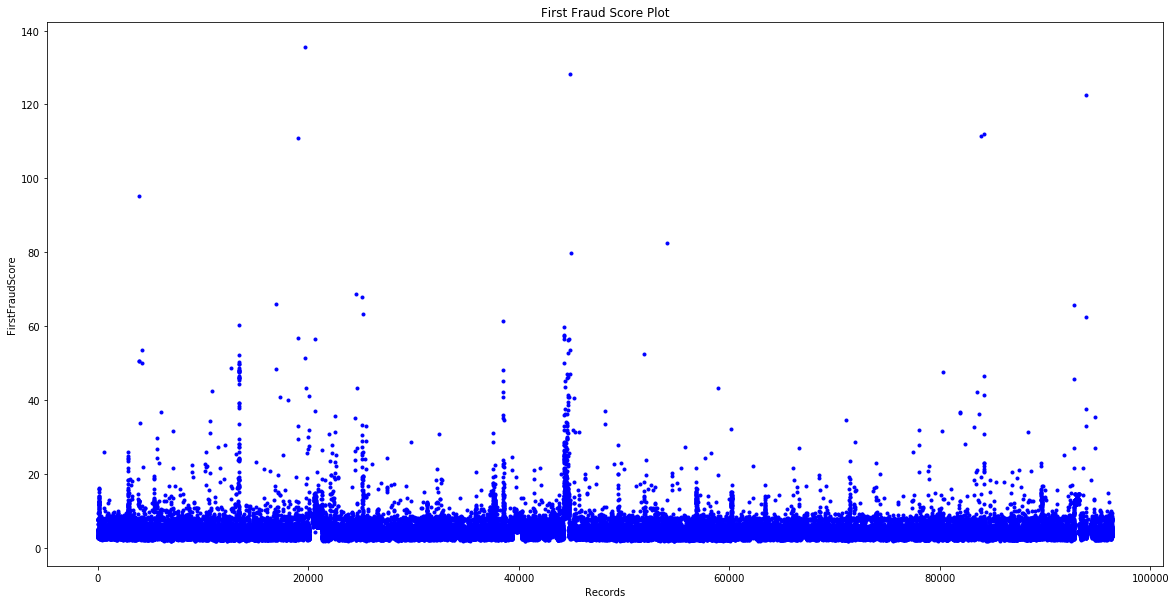

In [143]:
from matplotlib.pyplot import  figure
plt.figure(figsize=(20,10))
plt.plot(FirstFraudScore,'b.')
plt.xlabel('Records')
plt.ylabel('FirstFraudScore')
plt.title('First Fraud Score Plot')
plt.show()


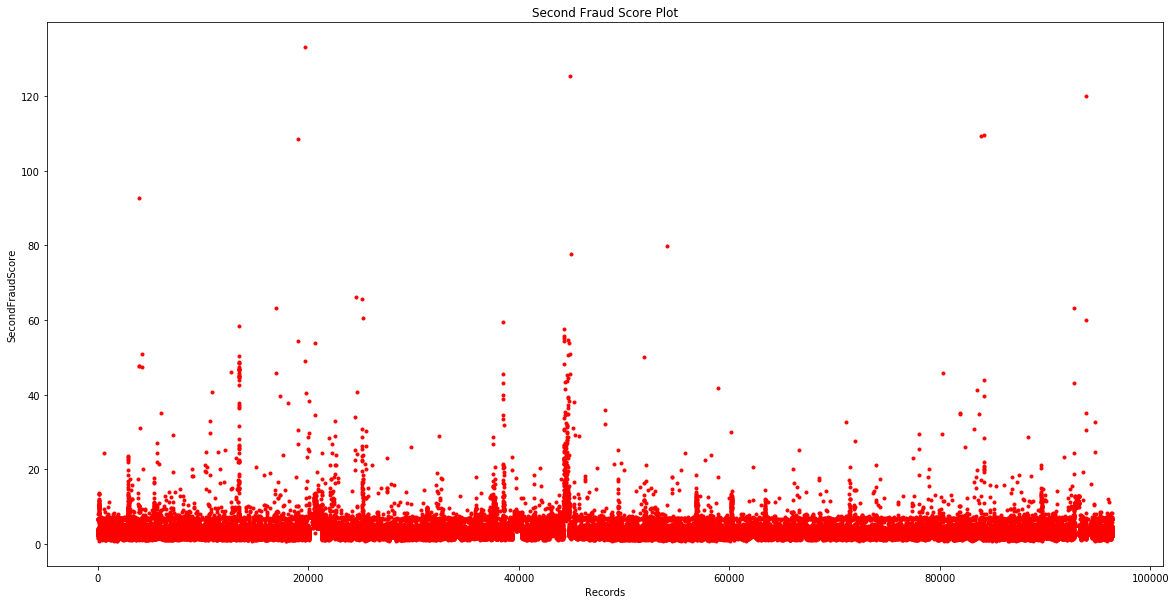

In [144]:
plt.figure(figsize=(20,10))
plt.plot(SecondFraudScore,'r.')
plt.xlabel('Records')
plt.ylabel('SecondFraudScore')
plt.title('Second Fraud Score Plot')
plt.show()

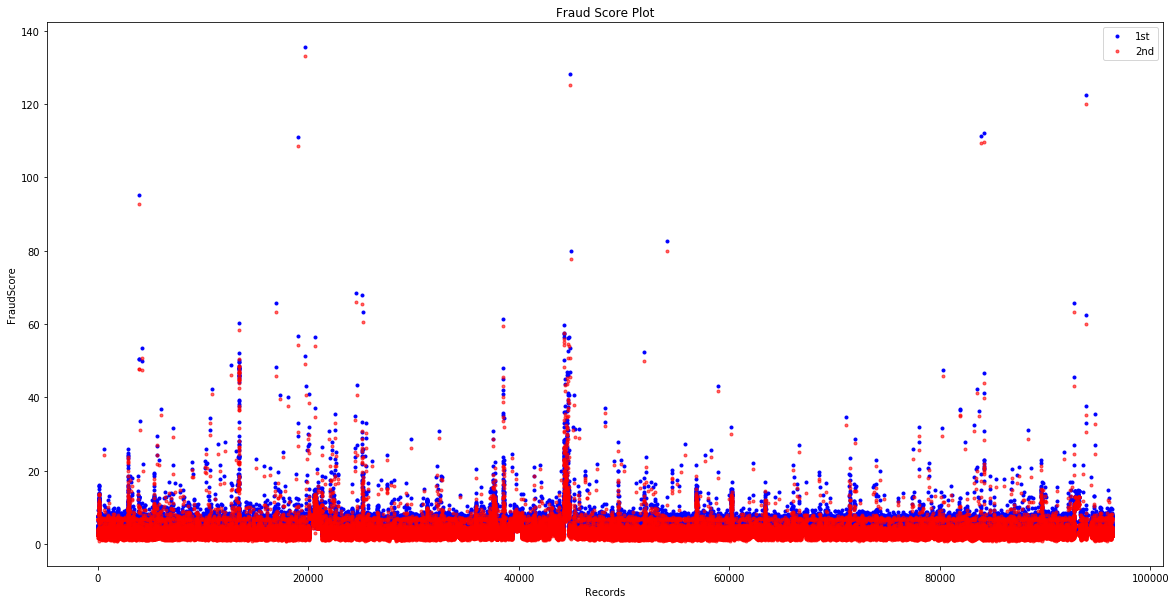

In [145]:
plt.figure(figsize=(20,10))
plt.plot(FirstFraudScore,'b.',label='1st')
plt.plot(SecondFraudScore,'r.',alpha=0.6,label='2nd')
plt.xlabel('Records')
plt.ylabel('FraudScore')
plt.title('Fraud Score Plot')
plt.legend()
plt.show()

In [146]:
AverageScore = (FirstFraudScore + SecondFraudScore)/2

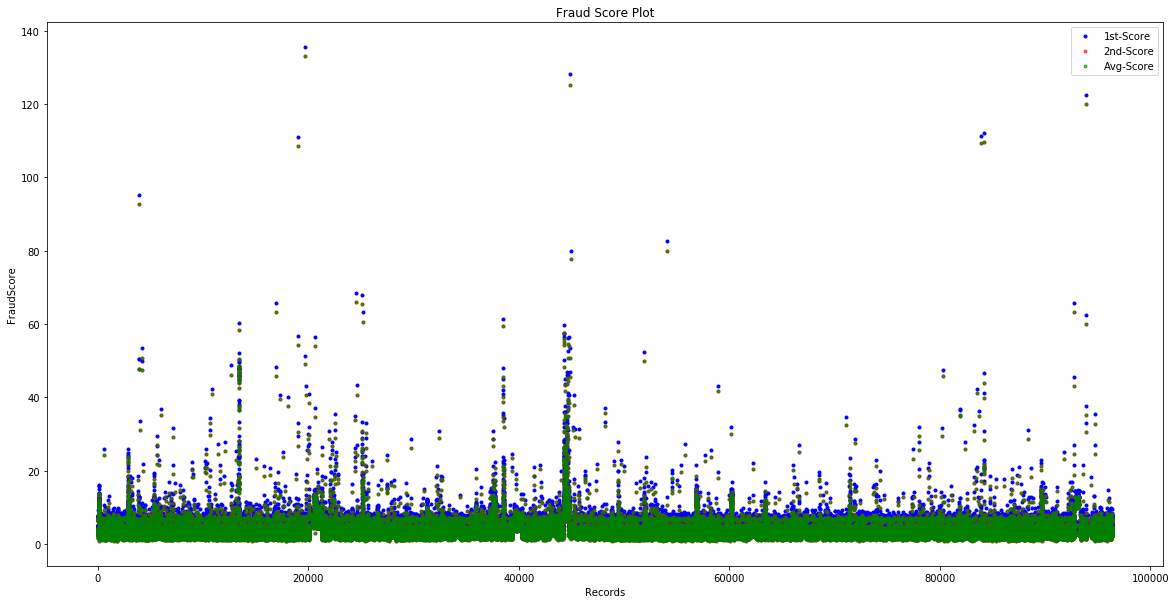

In [147]:
plt.figure(figsize=(20,10))
plt.plot(FirstFraudScore,'b.',label='1st-Score')
plt.plot(SecondFraudScore,'r.',alpha=0.6,label='2nd-Score')
plt.plot(SecondFraudScore,'g.',alpha=0.6,label='Avg-Score')
plt.xlabel('Records')
plt.ylabel('FraudScore')
plt.title('Fraud Score Plot')
plt.legend()
plt.show()

In [148]:
AverageScore.argsort()

array([54709, 25501, 80534, ..., 93891, 44825, 19649], dtype=int64)

In [149]:
"""
Probably take to 10% are outliers
"""

top10Percent = np.ceil(len(AverageScore)*.10).astype('int64')


In [150]:
FraudIndices = AverageScore.argsort()[:top10Percent]
FraudData = project1DataCopy.iloc[FraudIndices]

In [135]:
NonFraudIndices = AverageScore.argsort()[top10Percent:]
NonFraudData = project1DataCopy.iloc[NonFraudIndices]

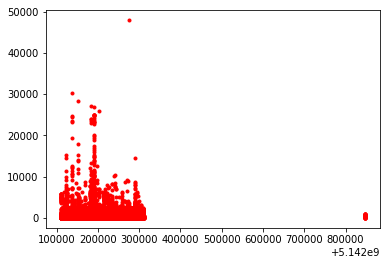

In [157]:
### Need to check which merchant or card is fraudulant